## CICIDS2017 Dataset

In [1]:
#Importing Libraries
import numpy as np 
import pandas as pd
import matplotlib
import seaborn as sns
sns.set(style='dark')
import sklearn 
import imblearn
import matplotlib.pyplot as plt
import time
import sklearn.metrics as m
import xgboost as xgb
import warnings # To ignore warnings
warnings.filterwarnings('ignore')


#Setting
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

df1 = pd.read_csv('C:/Users/yashp/Desktop/BE_project/cicids2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

df2 = pd.read_csv('C:/Users/yashp/Desktop/BE_project/cicids2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')

df3 = pd.read_csv('C:/Users/yashp/Desktop/BE_project/cicids2017/Friday-WorkingHours-Morning.pcap_ISCX.csv')

df5 = pd.read_csv('C:/Users/yashp/Desktop/BE_project/cicids2017/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')

df6 = pd.read_csv('C:/Users/yashp/Desktop/BE_project/cicids2017/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
# df4 is being left out as it only have the benign samples

In [2]:
print (df1[' Label'].unique())
print (df2[' Label'].unique())
print (df3[' Label'].unique())

print (df5[' Label'].unique())
print (df6[' Label'].unique())

['BENIGN' 'DDoS']
['BENIGN' 'PortScan']
['BENIGN' 'Bot']
['BENIGN' 'Infiltration']
['BENIGN' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection']


In [3]:
df = pd.concat([df1,df2])
del df1,df2
df = pd.concat([df,df3])
del df3

df = pd.concat([df,df5])
del df5
df = pd.concat([df,df6])
del df6

In [4]:
data = df.copy()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1162213 entries, 0 to 170365
Data columns (total 79 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0    Destination Port             1162213 non-null  int64  
 1    Flow Duration                1162213 non-null  int64  
 2    Total Fwd Packets            1162213 non-null  int64  
 3    Total Backward Packets       1162213 non-null  int64  
 4   Total Length of Fwd Packets   1162213 non-null  int64  
 5    Total Length of Bwd Packets  1162213 non-null  int64  
 6    Fwd Packet Length Max        1162213 non-null  int64  
 7    Fwd Packet Length Min        1162213 non-null  int64  
 8    Fwd Packet Length Mean       1162213 non-null  float64
 9    Fwd Packet Length Std        1162213 non-null  float64
 10  Bwd Packet Length Max         1162213 non-null  int64  
 11   Bwd Packet Length Min        1162213 non-null  int64  
 12   Bwd Packet Length Mean      

In [6]:
data[" Label"].value_counts()

BENIGN                        871074
PortScan                      158930
DDoS                          128027
Bot                             1966
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Name:  Label, dtype: int64

In [7]:
#Dropping Null values
#check for missing data
print(f"Missing values: {data.isnull().sum().sum()}")

#check for infinite values
data.replace([np.inf,-np.inf],np.nan,inplace=True)
print(f"Missing values: {data.isnull().sum().sum()}")

Missing values: 85
Missing values: 1738


In [8]:
deletecol = []
for column in data.columns:
    if data[column].isnull().values.any():
        deletecol.append(column)

for column in deletecol:
    data.drop([column],axis=1,inplace=True)

In [9]:
deletecol = []
for column in data.columns:
    if column == ' Label':
        continue
    elif data[column].dtype==np.object:
        deletecol.append(column)

for column in deletecol:
    data.drop(column,axis=1,inplace=True) #axis = 1 drop column and inplace=True to modify in that dataframe only

In [10]:
data[' Flow Duration'].unique()

array([       3,      109,       52, ..., 44797921,  1286687,  1387547],
      dtype=int64)

In [11]:
for column in data.columns:
    if data[column].dtype == np.int64:
        maxVal = data[column].max()
        if maxVal < 120:
            data[column] = data[column].astype(np.int8)
        elif maxVal < 32767:
            data[column] = data[column].astype(np.int16)
        else:
            data[column] = data[column].astype(np.int32)
            
    if data[column].dtype == np.float64:
        maxVal = data[column].max()
        minVal = data[data[column]>0][column]
        if maxVal < 120 and minVal>0.01 :
            data[column] = data[column].astype(np.float16)
        else:
            data[column] = data[column].astype(np.float32)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1162213 entries, 0 to 170365
Data columns (total 77 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0    Destination Port             1162213 non-null  int32  
 1    Flow Duration                1162213 non-null  int32  
 2    Total Fwd Packets            1162213 non-null  int32  
 3    Total Backward Packets       1162213 non-null  int32  
 4   Total Length of Fwd Packets   1162213 non-null  int32  
 5    Total Length of Bwd Packets  1162213 non-null  int32  
 6    Fwd Packet Length Max        1162213 non-null  int16  
 7    Fwd Packet Length Min        1162213 non-null  int16  
 8    Fwd Packet Length Mean       1162213 non-null  float32
 9    Fwd Packet Length Std        1162213 non-null  float32
 10  Bwd Packet Length Max         1162213 non-null  int16  
 11   Bwd Packet Length Min        1162213 non-null  int16  
 12   Bwd Packet Length Mean      

In [13]:
data[' Label'].value_counts()

BENIGN                        871074
PortScan                      158930
DDoS                          128027
Bot                             1966
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Name:  Label, dtype: int64

In [14]:
benign = data[data[' Label'] == 'BENIGN'].sample(frac=0.1).reset_index(drop=True)
attack = data[data[' Label'] != 'BENIGN']
data = pd.concat([attack, benign])
data[' Label'].value_counts()

PortScan                      158930
DDoS                          128027
BENIGN                         87107
Bot                             1966
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Name:  Label, dtype: int64

In [15]:
ddos = data[data[' Label'] == 'DDoS'].sample(frac=0.32).reset_index(drop=True)
attack = data[data[' Label'] != 'DDoS']
data = pd.concat([attack, ddos])
data[' Label'].value_counts()

PortScan                      158930
BENIGN                         87107
DDoS                           40969
Bot                             1966
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Name:  Label, dtype: int64

In [16]:
PortScan = data[data[' Label'] == 'PortScan'].sample(frac=0.32).reset_index(drop=True)
attack = data[data[' Label'] != 'PortScan']
data = pd.concat([attack, PortScan])
data[' Label'].value_counts()

BENIGN                        87107
PortScan                      50858
DDoS                          40969
Bot                            1966
Web Attack � Brute Force       1507
Web Attack � XSS                652
Infiltration                     36
Web Attack � Sql Injection       21
Name:  Label, dtype: int64

In [17]:
y = data[' Label']
X = data.drop([' Label'],axis=1)

### Feature Selection
1. Reduces Overfitting: Less redundant data means less possibility of making decisions based on redundant data/noise.
2. Improves Accuracy: Less misleading data means modeling accuracy improves.
3. Reduces Training Time: Less data means that algorithms train faster.

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concating two dataframes for better visualization 

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

print(featureScores.nlargest(30,'Score'))  

                          Specs         Score
12       Bwd Packet Length Mean  26334.323940
52         Avg Bwd Segment Size  26334.323940
13        Bwd Packet Length Std  23375.943834
10        Bwd Packet Length Max  23222.712365
39            Packet Length Std  21893.226361
50          Average Packet Size  21759.110098
38           Packet Length Mean  21751.692668
37            Max Packet Length  19614.298921
40       Packet Length Variance  15790.579644
44               PSH Flag Count  15524.663273
67         min_seg_size_forward  13978.496606
36            Min Packet Length   7456.572096
45               ACK Flag Count   6355.882255
4   Total Length of Fwd Packets   5430.102396
61            Subflow Fwd Bytes   5430.102396
11        Bwd Packet Length Min   5372.005317
65      Init_Win_bytes_backward   4987.430186
64       Init_Win_bytes_forward   4823.650853
20                  Fwd IAT Std   3541.286536
16                 Flow IAT Max   2946.284033
15                 Flow IAT Std   

In [19]:
feature = pd.DataFrame()
n = len(featureScores['Specs'])
for i in featureScores.nlargest(n//2,'Score')['Specs']:
        feature[i] = data[i]
feature[' Label'] = data[' Label']

In [20]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183116 entries, 24072 to 50857
Data columns (total 39 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0    Bwd Packet Length Mean      183116 non-null  float32
 1    Avg Bwd Segment Size        183116 non-null  float32
 2    Bwd Packet Length Std       183116 non-null  float32
 3   Bwd Packet Length Max        183116 non-null  int16  
 4    Packet Length Std           183116 non-null  float32
 5    Average Packet Size         183116 non-null  float32
 6    Packet Length Mean          183116 non-null  float32
 7    Max Packet Length           183116 non-null  int16  
 8    Packet Length Variance      183116 non-null  float32
 9    PSH Flag Count              183116 non-null  int8   
 10   min_seg_size_forward        183116 non-null  int8   
 11   Min Packet Length           183116 non-null  int16  
 12   ACK Flag Count              183116 non-null  int8   
 

<AxesSubplot:>

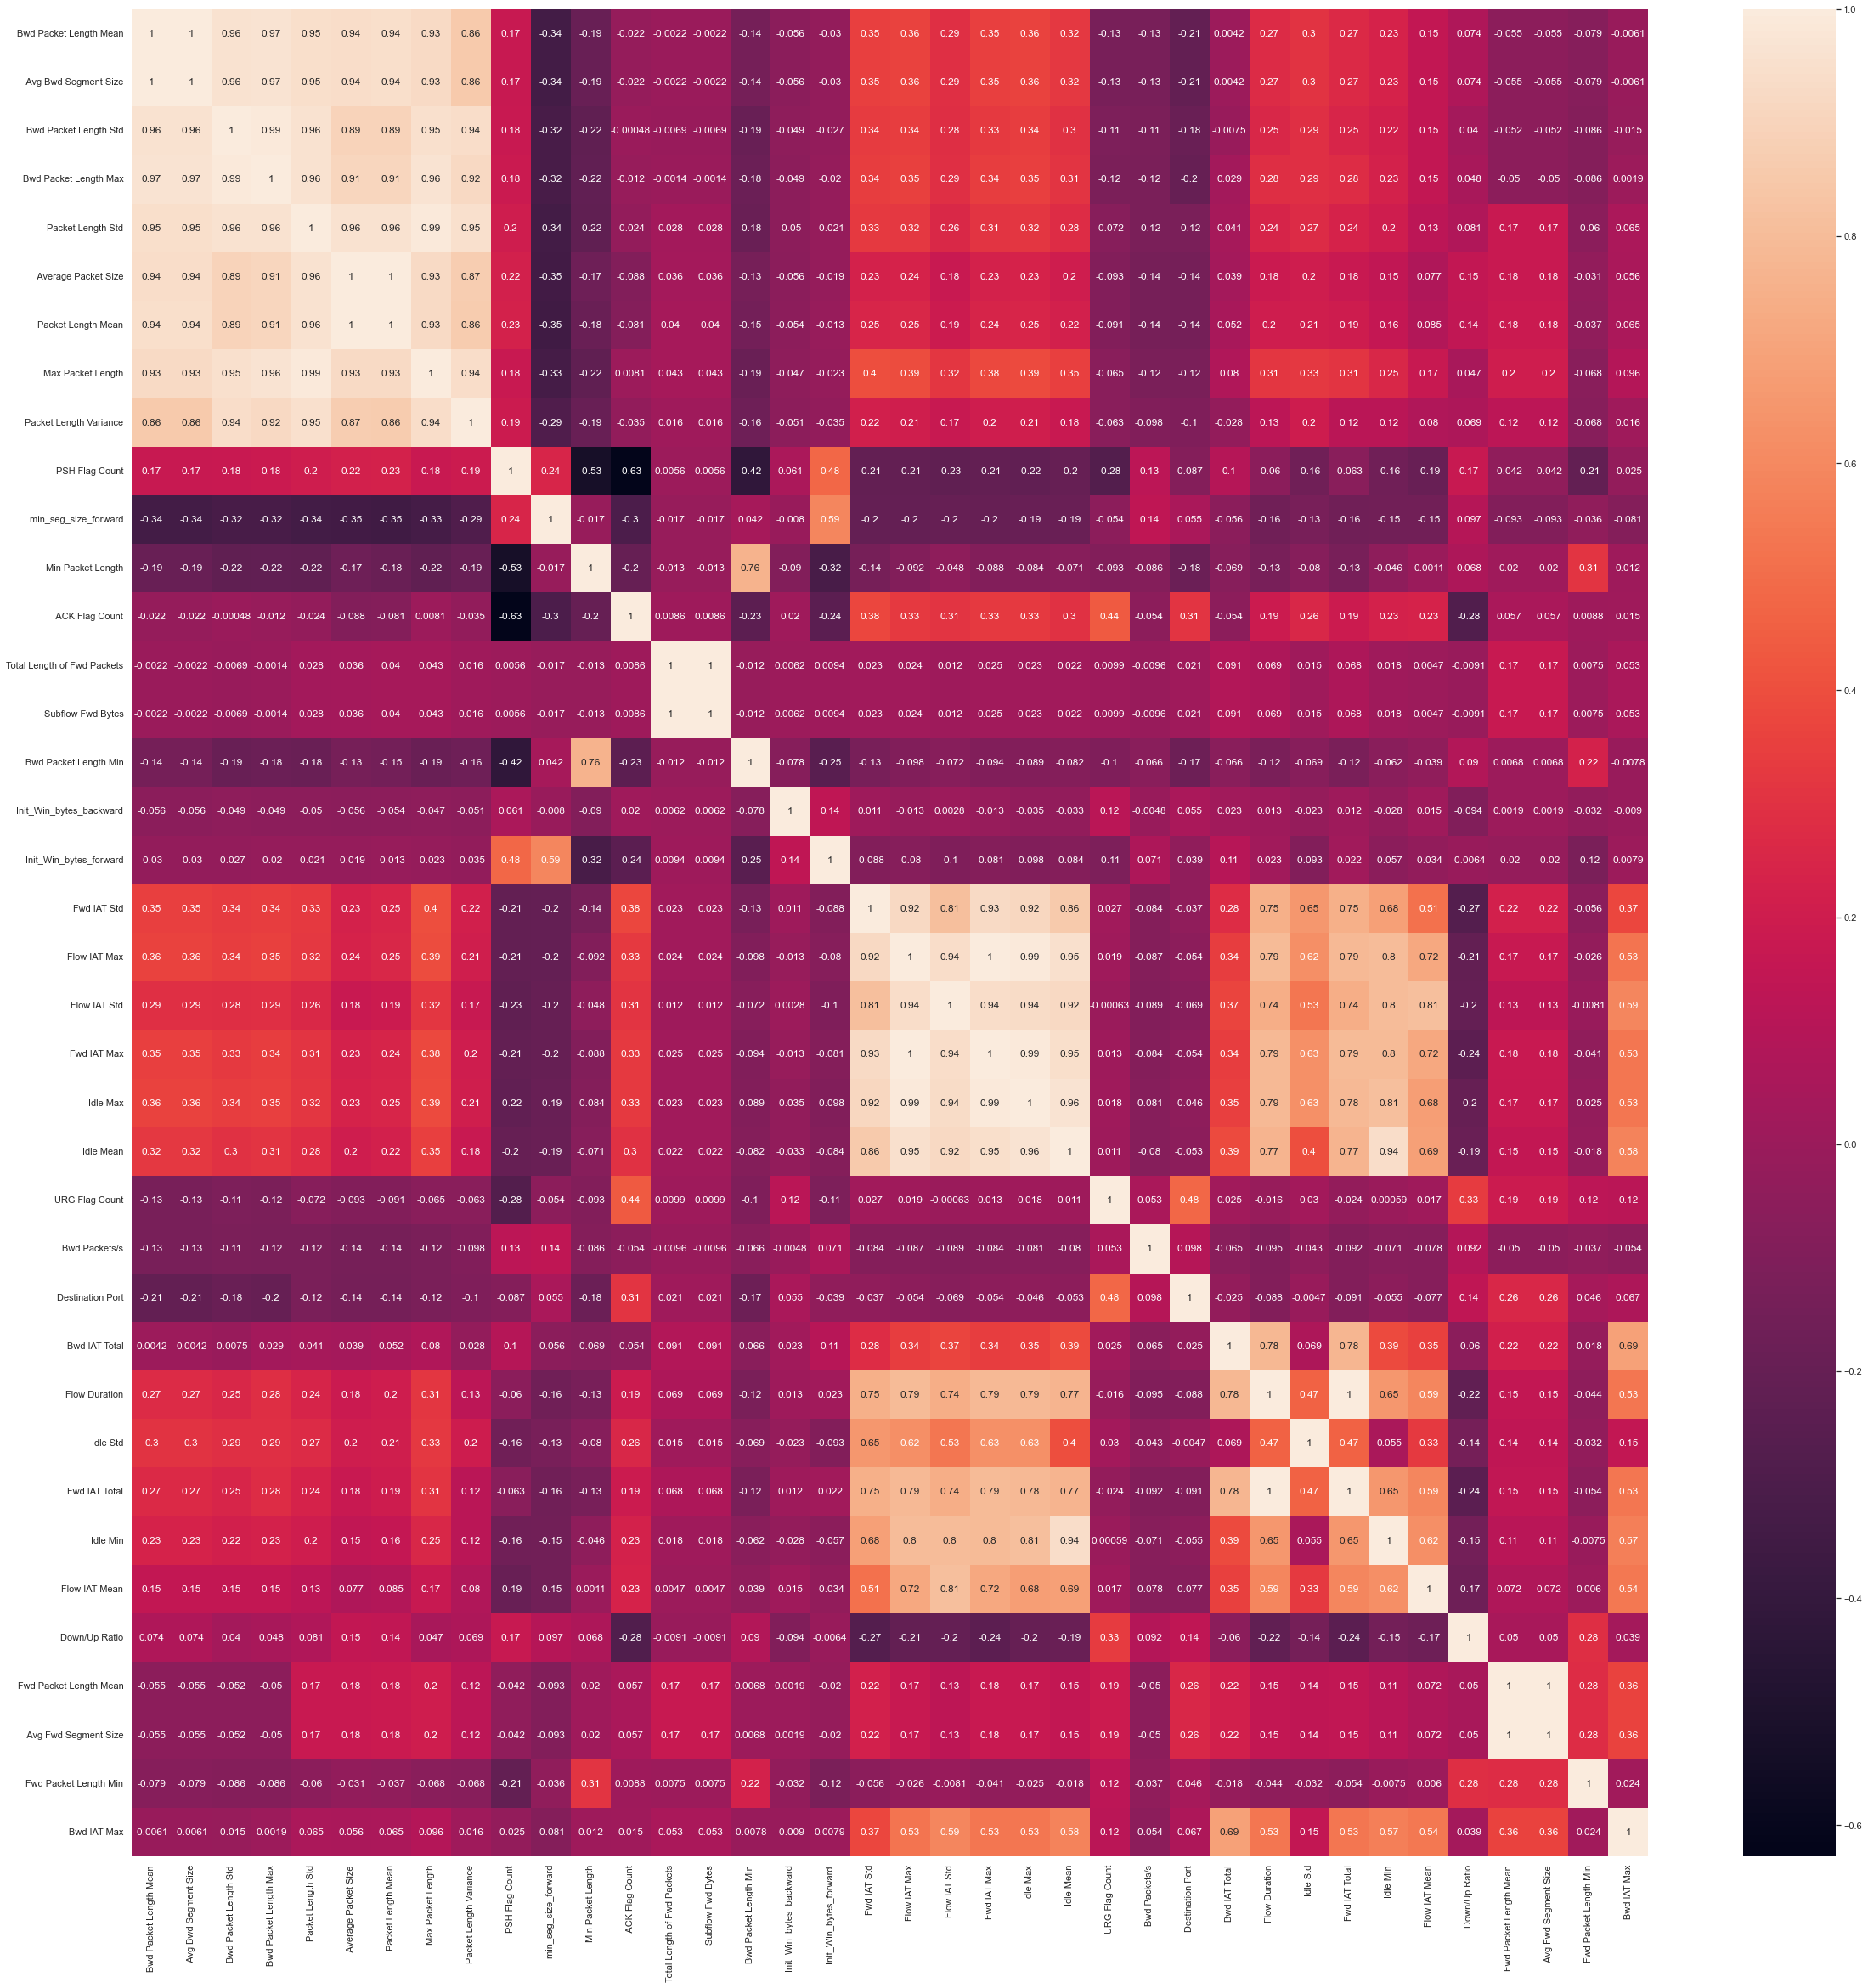

In [21]:
from matplotlib import pyplot as plt 
import seaborn as sns

fig= plt.figure(figsize=(40,40))
sns.heatmap(feature.corr(), annot=True)

Correlation, statistical technique which determines how one variables moves/changes in relation with the other variable. When we have highly correlated features in the dataset it increses the variance and unreliable.

Clearly there is an exellent correlation in -

- Bwd Packet Length Std
- Bwd Packet Length Mean
- Avg Bwd Segment Size
- Bwd Packet Length Max
- Packet Length Std
- Average Packet Size
- Packet Length Mean
- Max Packet Length
- Packet Length Variance

Also,correlattion lies in -

- Flow IAT Max
- Idle Max
- Fwd IAT Max
- Flow IAT Std
- Idle Std
- Idle Mean

In [22]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183116 entries, 24072 to 50857
Data columns (total 39 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0    Bwd Packet Length Mean      183116 non-null  float32
 1    Avg Bwd Segment Size        183116 non-null  float32
 2    Bwd Packet Length Std       183116 non-null  float32
 3   Bwd Packet Length Max        183116 non-null  int16  
 4    Packet Length Std           183116 non-null  float32
 5    Average Packet Size         183116 non-null  float32
 6    Packet Length Mean          183116 non-null  float32
 7    Max Packet Length           183116 non-null  int16  
 8    Packet Length Variance      183116 non-null  float32
 9    PSH Flag Count              183116 non-null  int8   
 10   min_seg_size_forward        183116 non-null  int8   
 11   Min Packet Length           183116 non-null  int16  
 12   ACK Flag Count              183116 non-null  int8   
 

In [23]:
feature.drop([' Bwd Packet Length Mean'],axis=1,inplace=True)
feature.drop([' Avg Bwd Segment Size'],axis=1,inplace=True)
feature.drop(['Bwd Packet Length Max'],axis=1,inplace=True)
feature.drop([' Packet Length Std'],axis=1,inplace=True)
feature.drop([' Average Packet Size'],axis=1,inplace=True)
feature.drop([' Packet Length Mean'],axis=1,inplace=True)
feature.drop([' Max Packet Length'],axis=1,inplace=True)
feature.drop([' Packet Length Variance'],axis=1,inplace=True)


feature.drop([' Idle Max'],axis=1,inplace=True)
feature.drop([' Fwd IAT Max'],axis=1,inplace=True)
feature.drop([' Flow IAT Std'],axis=1,inplace=True)
feature.drop([' Idle Std'],axis=1,inplace=True)
feature.drop(['Idle Mean'],axis=1,inplace=True)

<AxesSubplot:>

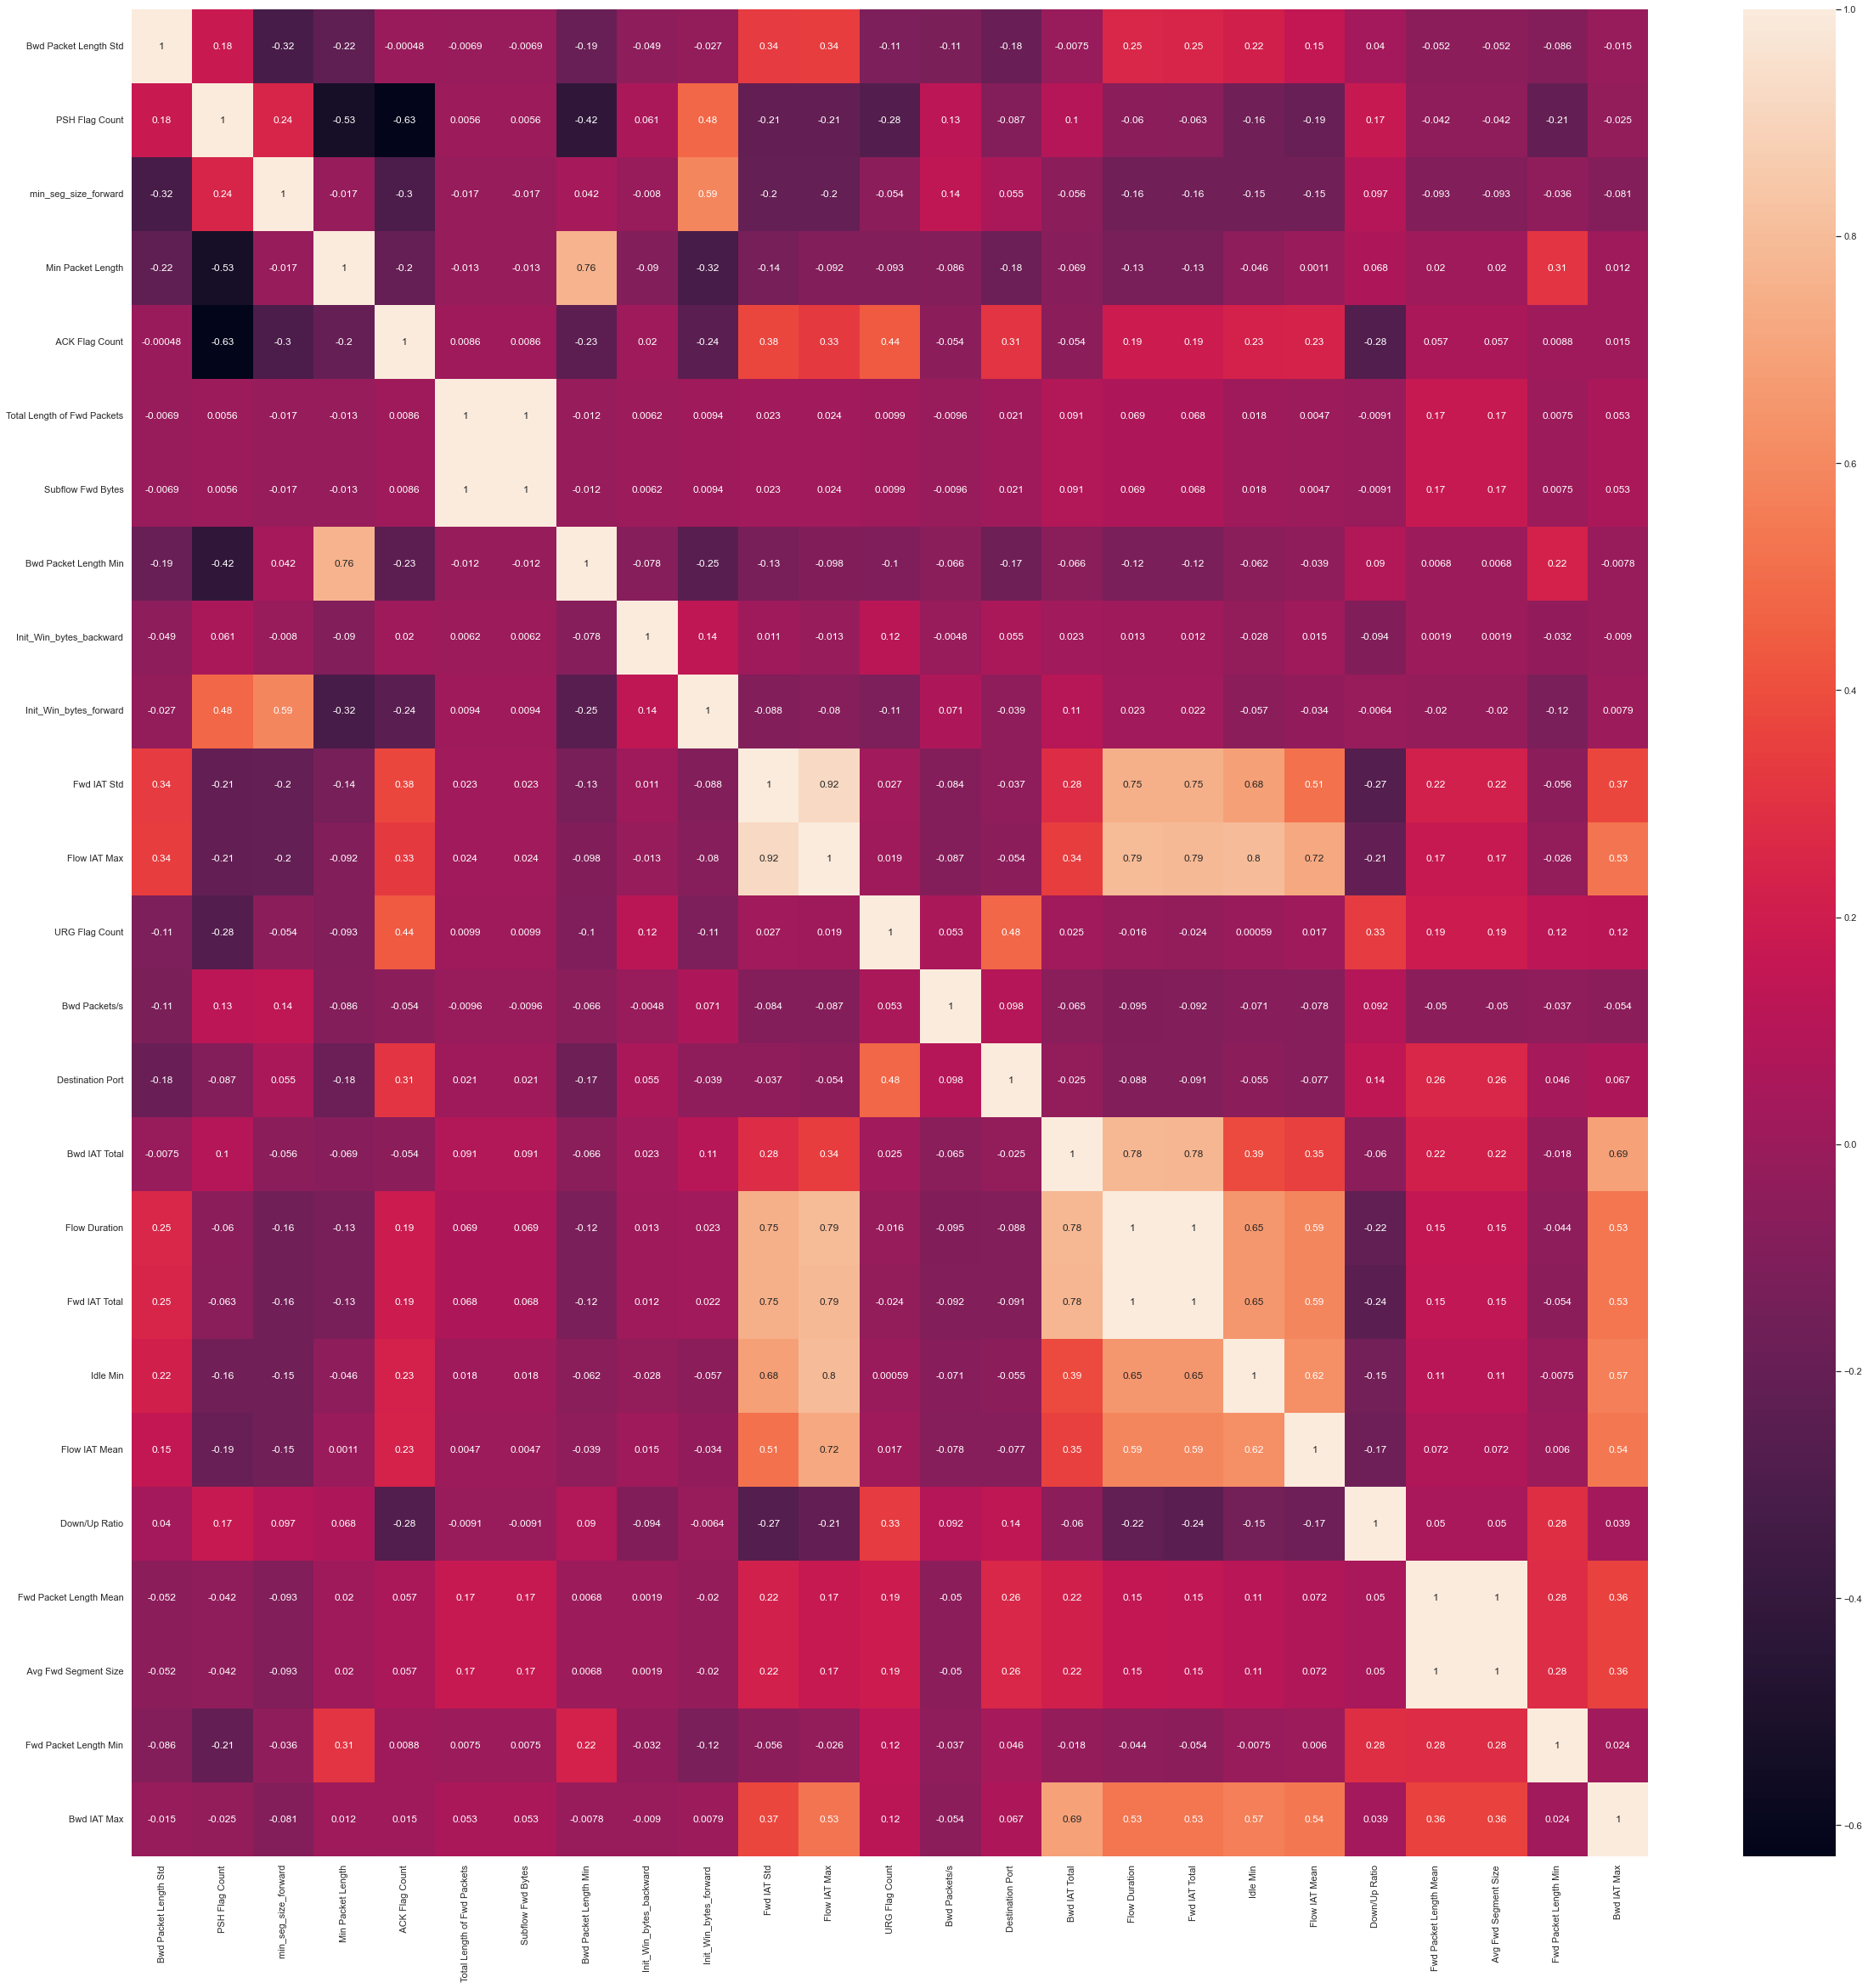

In [24]:
fig= plt.figure(figsize=(40,40))
sns.heatmap(feature.corr(), annot=True)

In [25]:
feature[' Label'].value_counts()

BENIGN                        87107
PortScan                      50858
DDoS                          40969
Bot                            1966
Web Attack � Brute Force       1507
Web Attack � XSS                652
Infiltration                     36
Web Attack � Sql Injection       21
Name:  Label, dtype: int64

In [26]:
attackType = feature[' Label'].unique()
feature[' Label'] = feature[' Label'].astype('category')
feature[' Label'] = feature[' Label'].astype("category").cat.codes

In [27]:
print (attackType)
print (feature[' Label'].value_counts())

['Bot' 'Infiltration' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'BENIGN' 'DDoS' 'PortScan']
0    87107
4    50858
2    40969
1     1966
5     1507
7      652
3       36
6       21
Name:  Label, dtype: int64


In [28]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183116 entries, 24072 to 50857
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0    Bwd Packet Length Std       183116 non-null  float32
 1    PSH Flag Count              183116 non-null  int8   
 2    min_seg_size_forward        183116 non-null  int8   
 3    Min Packet Length           183116 non-null  int16  
 4    ACK Flag Count              183116 non-null  int8   
 5   Total Length of Fwd Packets  183116 non-null  int32  
 6    Subflow Fwd Bytes           183116 non-null  int32  
 7    Bwd Packet Length Min       183116 non-null  int16  
 8    Init_Win_bytes_backward     183116 non-null  int32  
 9   Init_Win_bytes_forward       183116 non-null  int32  
 10   Fwd IAT Std                 183116 non-null  float32
 11   Flow IAT Max                183116 non-null  int32  
 12   URG Flag Count              183116 non-null  int8   
 

In [29]:
feature0 = feature[feature[' Label'] == 0]
feature0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87107 entries, 0 to 87106
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0    Bwd Packet Length Std       87107 non-null  float32
 1    PSH Flag Count              87107 non-null  int8   
 2    min_seg_size_forward        87107 non-null  int8   
 3    Min Packet Length           87107 non-null  int16  
 4    ACK Flag Count              87107 non-null  int8   
 5   Total Length of Fwd Packets  87107 non-null  int32  
 6    Subflow Fwd Bytes           87107 non-null  int32  
 7    Bwd Packet Length Min       87107 non-null  int16  
 8    Init_Win_bytes_backward     87107 non-null  int32  
 9   Init_Win_bytes_forward       87107 non-null  int32  
 10   Fwd IAT Std                 87107 non-null  float32
 11   Flow IAT Max                87107 non-null  int32  
 12   URG Flag Count              87107 non-null  int8   
 13   Bwd Packets/s  

In [30]:
y = feature[' Label']
X = feature.drop([' Label'],axis=1)

In [32]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler('majority')
X_rus, y_rus = rus.fit_resample(X, y)

In [33]:
y_rus.value_counts()

4    50858
2    40969
1     1966
5     1507
7      652
3       36
0       21
6       21
Name:  Label, dtype: int64

In [34]:
df = X_rus
df[' Label'] = y_rus
minor = pd.DataFrame(df[(df[' Label']!=4) & (df[' Label']!=2)])
major = pd.DataFrame(df[(df[' Label']==4) | (df[' Label']==2)])
minor[' Label'].value_counts()

1    1966
5    1507
7     652
3      36
0      21
6      21
Name:  Label, dtype: int64

In [35]:
from imblearn.over_sampling import SMOTE
y_rus_ =  minor[' Label']
X_rus_ =  minor.drop([' Label'],axis=1)
strategy = {1:2000, 5:1600, 7:800, 3:300, 6:200, 0:200}
sm = SMOTE(sampling_strategy=strategy)
X_sm, y_sm = sm.fit_resample(X_rus_, y_rus_)
X_min,y_min = X_sm, y_sm 

In [36]:
major[' Label'].value_counts()

4    50858
2    40969
Name:  Label, dtype: int64

In [37]:
from imblearn.under_sampling import RandomUnderSampler
y_rus_ =  major[' Label']
X_rus_ =  major.drop([' Label'],axis=1)
strategy = {4:10000, 2:6000}
tom = RandomUnderSampler(sampling_strategy=strategy)
X_tom, y_tom = tom.fit_resample(X_rus_, y_rus_)
y_tom.value_counts()

4    10000
2     6000
Name:  Label, dtype: int64

In [38]:
X_maj,y_maj = X_tom, y_tom
X,y = pd.concat([X_maj,X_min]), pd.concat([y_maj,y_min])
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21100 entries, 0 to 5099
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0    Bwd Packet Length Std       21100 non-null  float32
 1    PSH Flag Count              21100 non-null  int8   
 2    min_seg_size_forward        21100 non-null  int8   
 3    Min Packet Length           21100 non-null  int16  
 4    ACK Flag Count              21100 non-null  int8   
 5   Total Length of Fwd Packets  21100 non-null  int32  
 6    Subflow Fwd Bytes           21100 non-null  int32  
 7    Bwd Packet Length Min       21100 non-null  int16  
 8    Init_Win_bytes_backward     21100 non-null  int32  
 9   Init_Win_bytes_forward       21100 non-null  int32  
 10   Fwd IAT Std                 21100 non-null  float32
 11   Flow IAT Max                21100 non-null  int32  
 12   URG Flag Count              21100 non-null  int8   
 13   Bwd Packets/s   

## Models

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = X.select_dtypes(include=['float32','float16','int32','int16','int8']).columns
train_X = scaler.fit_transform(X.select_dtypes(include=['float32','float16','int32','int16','int8']))



from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(train_X,y,train_size=0.70, random_state=2)


from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Training Random Forest
RFC_Classifier = RandomForestClassifier(max_depth=40)
RFC_Classifier.fit(X_train, Y_train)
print ('RF Classifier run')

# Training SVC
SVM_Classifier = SVC()
SVM_Classifier.fit(X_train, Y_train)
print ('SV Classifier run')
# Training Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='gini', max_depth=33, random_state=20, max_features=12, splitter='random')
DTC_Classifier.fit(X_train, Y_train)
print ('DTC Classifier run')

RF Classifier run
SV Classifier run
DTC Classifier run


In [40]:
from sklearn import metrics

models = []
models.append(('Random Forest Classifier', RFC_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
models.append(('Support Vector Classifier',SVM_Classifier))


for i, v in models:
    Xpred =  v.predict(X_train)
    scores = cross_val_score(v, X_train, Y_train, cv=10)
    accuracy = metrics.accuracy_score(Y_train, Xpred)
    confusion_matrix = metrics.confusion_matrix(Y_train, Xpred)
    classification = metrics.classification_report(Y_train, Xpred)
    print()
    print('============================== {} Model Evaluation =============================='.format(i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


============================== Random Forest Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.959442664670384

Model Accuracy:
 0.9991874873044891

Confusion matrix:
 [[ 139    0    0    0    1    0    0    0]
 [   0 1359    0    0    0    0    0    0]
 [   0    0 4232    0    0    0    0    0]
 [   0    0    0  197    0    0    0    0]
 [   0    0    0    0 7034    0    0    0]
 [   0    0    0    0    0 1103    0    2]
 [   0    0    0    0    0    0  142    0]
 [   0    0    0    0    0    9    0  551]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       140
           1       1.00      1.00      1.00      1359
           2       1.00      1.00      1.00      4232
           3       1.00      1.00      1.00       197
           4       1.00      1.00      1.00      7034
           5       0.99      1.00      1.00      1105
           6       1.00      1.00      1

In [41]:
for i, v in models:
    pred = v.predict(X_test)
    accuracy = metrics.accuracy_score(Y_test,pred)
    confusion_matrix = metrics.confusion_matrix(Y_test, pred)
    classification = metrics.classification_report(Y_test, pred)
    print()
    print('============================== {} Model Test Results =============================='.format(i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()    


============================== Random Forest Classifier Model Test Results ==============================

Model Accuracy:
 0.958300426472911

Confusion matrix:
 [[  57    2    0    0    0    0    0    1]
 [   0  641    0    0    0    0    0    0]
 [   0    0 1766    0    2    0    0    0]
 [   0    1    0  102    0    0    0    0]
 [   0    0    0    0 2966    0    0    0]
 [   0    0    0    0    0  376    0  119]
 [   0    0    0    0    0    0   58    0]
 [   0    0    0    0    1  136    2  101]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        60
           1       1.00      1.00      1.00       641
           2       1.00      1.00      1.00      1768
           3       1.00      0.99      1.00       103
           4       1.00      1.00      1.00      2966
           5       0.73      0.76      0.75       495
           6       0.97      1.00      0.98        58
           7       0.46      0.42 

## Ensemble Model

In [42]:
from sklearn.ensemble import VotingClassifier

clf1 = tree.DecisionTreeClassifier(criterion='gini', max_depth=33, random_state=20, max_features=12, splitter='random')
clf2 = RandomForestClassifier(criterion='gini', max_depth=40, random_state=20)
clf3 = SVC()

votingC = VotingClassifier(estimators=[('dc',clf1), ('rf', clf2),('svc',clf3)],voting='hard', weights=[2,2,1],flatten_transform=True)
votingC.fit(X_train,Y_train)

VotingClassifier(estimators=[('dc',
                              DecisionTreeClassifier(max_depth=33,
                                                     max_features=12,
                                                     random_state=20,
                                                     splitter='random')),
                             ('rf',
                              RandomForestClassifier(max_depth=40,
                                                     random_state=20)),
                             ('svc', SVC())],
                 weights=[2, 2, 1])

In [43]:
pred = votingC.predict(X_test)
accuracy = metrics.accuracy_score(Y_test,pred)
confusion_matrix = metrics.confusion_matrix(Y_test, pred)
classification = metrics.classification_report(Y_test, pred)
print()
print('============================== {} Model Test Results =============================='.format('Voting Classifier'))
print()
print ("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("Classification report:" "\n", classification) 
print()    


============================== Voting Classifier Model Test Results ==============================

Model Accuracy:
 0.9592481440530722

Confusion matrix:
 [[  58    1    0    0    0    0    0    1]
 [   0  641    0    0    0    0    0    0]
 [   0    0 1768    0    0    0    0    0]
 [   0    1    0  102    0    0    0    0]
 [   0    0    0    0 2966    0    0    0]
 [   0    0    0    0    0  391    2  102]
 [   0    0    0    0    0    0   58    0]
 [   0    0    0    0    1  149    1   89]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        60
           1       1.00      1.00      1.00       641
           2       1.00      1.00      1.00      1768
           3       1.00      0.99      1.00       103
           4       1.00      1.00      1.00      2966
           5       0.72      0.79      0.76       495
           6       0.95      1.00      0.97        58
           7       0.46      0.37      0

### accuracy of 96% and F1-score of 89%

In [45]:
import pickle

In [49]:
with open('CICIDS_DTC','wb') as f:
    pickle.dump(clf1,f)

In [50]:
with open('CICIDS_RFC','wb') as f:
    pickle.dump(clf2,f)

In [51]:
with open('CICIDS_SVM','wb') as f:
    pickle.dump(clf3,f)

In [ ]:
with open('CICIDS_RFC','rb') as f:
    m = pickle.load(f)